In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle, re

In [2]:
transcripts = pd.read_csv('data/raw/transcripts.csv')
transcripts.head(), transcripts.shape

(                                          transcript  \
 0  Good morning. How are you?(Laughter)It's been ...   
 1  Thank you so much, Chris. And it's truly a gre...   
 2  (Music: "The Sound of Silence," Simon & Garfun...   
 3  If you're here today — and I'm very happy that...   
 4  About 10 years ago, I took on the task to teac...   
 
                                                  url  
 0  https://www.ted.com/talks/ken_robinson_says_sc...  
 1  https://www.ted.com/talks/al_gore_on_averting_...  
 2  https://www.ted.com/talks/david_pogue_says_sim...  
 3  https://www.ted.com/talks/majora_carter_s_tale...  
 4  https://www.ted.com/talks/hans_rosling_shows_t...  , (2467, 2))

## Filtering out Transcripts with Special Characters
> After eyeballing, we found out some talks containing special characters. As such, regex is used to filter out the talks with special characters, such as ♫, ♪, chinese characters(送你从葱), math symbols (∇ ²) and greek symbols (τ). For simplicity sake, we will discard the 71 talk transcripts.

In [3]:
# general processing
transcripts.transcript = transcripts.transcript.str.replace('’',"'")

In [4]:
# filter out transcripts with special characters
from string import punctuation
transcript_with_special_char = []
eg = None
for t,url in transcripts.itertuples(index=False):
    if re.match("^([A-Za-z ]|[0-9]|[@_!#$%^&*()<>?\/|}{~:.,'\";-—-+=…€])+$",t)==None:
        transcript_with_special_char.append(url)
        if not eg:
            eg=url,t
print(len(transcript_with_special_char))
print('Example: {}'.format(eg[0]))
print('Transcript: {}'.format(eg[1]))

71
Example: https://www.ted.com/talks/nora_york_sings_what_i_want

Transcript: I'd like to begin this song I wrote about ceaseless yearning and never-ending want with a poem of popular Petrarchan paradoxes by Sir Thomas Wyatt the Elder: "I find no peace, and all my war is done; I fear and hope, I burn and freeze like ice; I fly above the wind, and yet I cannot arise; And naught I have, and all the world I seize upon."♫ I want what I can't have, need what I can't want ♫♫ Have what I don't have, what I want ♫♫ What I can't have, need what I can't want ♫♫ Have what I don't have, what I want ♫♫ What I can't have, need what I can't want ♫♫ Have what I don't have, what I want ♫♫ What I can't have, need what I can't want ♫♫ Have what I don't have, what I want ♫♫ What I can't have, need what I can't want ♫♫ Have but I don't have ♫♫ It feels like all I got is loss on a bad back ♫♫ Gone with the last train, honey don't you fret ♫♫ Every cloud has a silver lining ♫♫ Just a little rain, just a lit

In [5]:
transcripts = transcripts[(~transcripts.url.isin(transcript_with_special_char))]
transcripts.shape

(2396, 2)

## Analyze with Rating

In [6]:
# some preprocessing
import spacy, re, contractions

nlp = spacy.load("en_core_web_sm")


def simple_preoprocess(text):
    '''
    Steps:
        1. fix the contractions (e.g. don't --> do not)
        2. remove words in the brackets (e.g. (laughter))
        3. convert to spacy nlp 
    '''
    fixed_contractions = contractions.fix(text)  # 1
    removed_brackets = re.sub("[\(].*?[\)]", " ", fixed_contractions) # 2
    doc = nlp(removed_brackets)
    return doc

In [7]:
rating_ratio_df = pd.read_csv('data/output/rating_ratio_df.csv')
# rating_ratio_df.head(2)

In [8]:
rating_transcript_df = rating_ratio_df.merge(transcripts,on='url')
rating_transcript_df.head(2)

,OK,Funny,Ingenious,Longwinded,Persuasive,Courageous,Jaw-dropping,Unconvincing,Inspiring,Informative,Fascinating,Beautiful,Obnoxious,Confusing,url,transcript
0,0.012509,0.209323,0.064710,0.004124,0.114054,0.034662,0.047299,0.003197,0.265573,0.078274,0.112744,0.048727,0.002227,0.002579,https://www.ted.com/talks/ken_robinson_says_sc...,Good morning. How are you?(Laughter)It's been ...
1,0.069142,0.185286,0.019074,0.038488,0.091281,0.047343,0.039510,0.087875,0.140668,0.150886,0.044959,0.019755,0.044619,0.021117,https://www.ted.com/talks/al_gore_on_averting_...,"Thank you so much, Chris. And it's truly a gre..."


### Analyse Ratings with Avg & Median sentence length###
><b>Hypothesis:</b><br> 
    Transcripts with longer sentences may have the tendancy to lose the attention of the audience, and thus audience would find the talk more longwinded and confusing. The duration has the a very weak positive correlation with Longwinded but not Confusing. 
    
><b>Analysis:</b>
    <br>However, from the correlation values, the correlation is near zero, and thus the mean and median sentence lengths do not indicate whether a talk is longwinded and confusing.
    <br><br>The scatter plot and the number of overlapping talks between the top 50 longwinded talks and the top 50 mean sentence length talks further proves that the hypothesis is not supported.
    

In [9]:
def generate_sentence_length(transcript):
    doc = simple_preoprocess(transcript)    
    lengths = [len(s) for s in doc.sents]
    return lengths

sent_length_df = rating_transcript_df.copy()
sent_length_df['len'] = rating_transcript_df.transcript.map(generate_sentence_length)

In [10]:
from statistics import median

sent_length_df['avg_len'] = sent_length_df.len.map(lambda x: sum(x)/len(x))
sent_length_df['median_len'] = sent_length_df.len.map(lambda x: median(x))

In [11]:
# corr between mean sentence length and median sentence length, and the ratings
sent_length_df.corr()[['avg_len','median_len']]

,avg_len,median_len
OK,0.002289,0.004594
Funny,-0.289711,-0.290114
Ingenious,-0.018536,-0.008602
Longwinded,0.077227,0.052946
Persuasive,0.149536,0.121312
Courageous,-0.011289,-0.019409
Jaw-dropping,-0.131181,-0.121316
Unconvincing,0.021711,0.009021
Inspiring,-0.006287,-0.014888
Informative,0.299087,0.305771


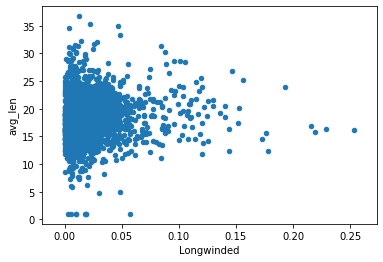

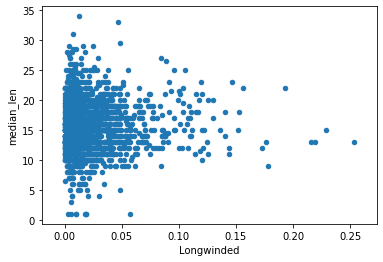

In [12]:
sent_length_df[['Longwinded','avg_len']].plot(kind='scatter',x='Longwinded',y='avg_len')
sent_length_df[['Longwinded','median_len']].plot(kind='scatter',x='Longwinded',y='median_len')

In [13]:
# get the top 50 longwinded talks and the top 50 mean sentence length talks to see the overlap
top_longwinded = sent_length_df.sort_values('Longwinded',ascending=False).iloc[:50]['url']
top_mean_sentence_length = sent_length_df.sort_values('avg_len',ascending=False).iloc[:50]['url']
print("number of overlaps between the top 50 longwinded talks and the top 50 mean sentence length talks:")
print(len(set(top_longwinded) & set(top_mean_sentence_length)))

number of overlaps between the top 50 longwinded talks and the top 50 mean sentence length talks:
1


### Analyze with Audience Reactions###
><b>Hypothesis:</b><br>
    As the transcripts include the audience and background reactions, it is hypothesized that if audience laugh a lot in a talk, they may have the tendancy to find the talk funny; other reactions may indicate other attributes of the talk.
    
><b>Analysis:</b><br>
    The phrases in the parenthesis are extracted and there is much noise data. The most commons ones are analyzed and similar ones are aggregated. 
    From the correlation result, the following correlations stand out:<ul>
    <li>There is a good positive correlation between Funny and Laugh count with the value of 0.603781. This indicates that the more the audience laugh the higher chance the audience would give the talk a "Funny" rating.</li>
    <li>For Informative, the correlations between that and Laugh count, and Applause count are negative. This may be because that for talks rated as Informative the most, they serve as knowledge sharing sessions for the audience, instead of those with jokes and performances. </li>
    <li>As the flip slide of the previous point, for talks rated as Jaw-dropping the most, the audience tends to applause a lot, as the talk may contain things that the audience do not expect at all.</li>

In [9]:
audience_reaction_df = rating_transcript_df.copy()
audience_reaction_df['reaction'] = rating_transcript_df.transcript.map(lambda x:re.findall('\(([^)]+)\)',x))

In [10]:
reaction_corpus=set()
all_reactions= []
for r in audience_reaction_df.reaction:
    reaction_corpus = set(r) | reaction_corpus
    all_reactions.extend(r)
len(reaction_corpus) # many noise data here 

785

In [11]:
from collections import Counter
c = Counter(all_reactions)
c.most_common(20)

[('Laughter', 10011),
 ('Applause', 5251),
 ('Music', 530),
 ('Video', 311),
 ('Audio', 54),
 ('Laughs', 49),
 ('Music ends', 44),
 ('Applause ends', 42),
 ('Cheers', 39),
 ('Singing', 34),
 ('Beatboxing', 17),
 ('English', 17),
 ('Cheering', 16),
 ('Sighs', 16),
 ('k', 16),
 ('Whistling', 15),
 ('Guitar', 14),
 ('Guitar strum', 14),
 ('Sings', 13),
 ('Audience', 12)]

In [12]:
audience_reaction_df['laugh_count'] = audience_reaction_df.reaction.map(lambda x: len([r for r in x if r =='Laughter' or r == 'Laughs']))
audience_reaction_df['applause_count'] = audience_reaction_df.reaction.map(lambda x: len([r for r in x if 'Applause' in r]))

In [13]:
# correlation results
audience_reaction_df.corr()[['laugh_count','applause_count']]

,laugh_count,applause_count
OK,-0.137406,-0.258776
Funny,0.628123,0.161494
Ingenious,0.012971,0.053914
Longwinded,-0.003550,-0.154451
Persuasive,-0.135416,-0.119936
Courageous,-0.050884,0.119973
Jaw-dropping,-0.000184,0.220833
Unconvincing,-0.122059,-0.164080
Inspiring,-0.032594,0.155343
Informative,-0.227705,-0.295182


## Key word extraction with TF-IDF##
<b>Approach:</b>We explored the information and keyword extraction from the TED Talks using TFIDF metric.

### Pre-processing###
>For the preprocessing of the transcripts, besides the standard removal of stopwords, punctuations and non-alphabetic characters, we add in the Named Entity Recognition and isolate entity as single tokens, such as "the Great Wall of China" as one token. This is due to the nature of the TED Talks where there are talks about particular entities and there are speakers who also bring in real-world examples. If the entities were to split up into individual words as tokens, the information would be lost.

In [14]:
def create_doc_entity_list(doc):
    entity_index = []
    for ent in doc.ents:
        entity_index.append((ent.start, ent.end-1,ent.label_))
    return entity_index

def tokenize_doc(doc, min_word_length=2):
    '''
    This function takes in a spacy doc (after apply simple_preoprocess function on a talk transcript string)
        identifies the various entities
        remove stopwords, punctuations and numeric values
    returns the lemmatized tokens in lowercase with length >=2, along with the entities

    Considering that TED Talks consist of a wide variety of topics, most entity types are kept to ensure no information is lost  
    '''
    entity_index = create_doc_entity_list(doc)
    entity = ''
    tokens = []
    for i, token in enumerate(doc):
        is_entity = False
        for ent in entity_index:
            if i >= ent[0] and i <= ent[1]:
                if ent[2] not in ['DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']:
                    if entity =='':
                        entity = token.text
                    else:
                        entity += " "+token.text
                is_entity = True
        if is_entity:
            continue
        if entity != '':
            tokens.append(entity)
            entity = ''
        if token.is_stop == False and token.is_alpha == True and len(token.lemma_) >= 2:
            tokens.append(token.lemma_.lower())
    return tokens

def preprocess(transcript):
    doc = simple_preoprocess(transcript)
    tokens = tokenize_doc(doc)
    return tokens

In [ ]:
# processed_docs = transcripts.transcript.map(preprocess)
# pickle.dump(processed_docs,open('./data/pickle/processed_docs.p','wb'))
# processed_docs.head()

In [15]:
processed_docs = pickle.load(open('./data/pickle/processed_docs.p','rb'))

### TF-IDF computation###
>To compute the TFIDF value for each word in each document, we first use a dictionary to find the document frequency for each word to compute the inverse document frequency (IDF). After that, we loop through the whole corpus, with a threshold of 5 for term frequency, we computed the TFIDF value. Finally, for each document, we sorted the tokens by the TFIDF value in a reversed order to obtain the most important tokens. 


In [16]:
# compute IDF for each word
import math

# create a dict to count number of doc that contains the word for all words
doc_freq_dict = {}
for tokens in processed_docs:
    words_set = set(tokens)
    for word in words_set:
        if word in doc_freq_dict:
            doc_freq_dict[word] += 1
        else:
            doc_freq_dict[word] = 1

doc_count = len(processed_docs)
idf_dict = {}
for word in doc_freq_dict:
    idf_dict[word] = math.log(doc_count/doc_freq_dict[word])

In [17]:
# compute TFIDF together
tfidf_dict = {} # doc url: [(token,tfidf value)]
for i, doc in enumerate(processed_docs):
    d = {}
    for word in set(doc):
        tf = doc.count(word)
        if tf < 5:  # threshold for tf
            continue
        d[word]=doc.count(word) * idf_dict[word] / len(doc)
    tfidf_dict[transcripts.iloc[i,1]] = sorted([(k,v) for k,v in d.items()],reverse=True,key=lambda x:x[1])

### Check the results ###

> To evaluate the results, we randomly select 5 talks with their top 5 words based on TF-IDF metric. We used the 5 words as the search keywords in ted.com to see if can corresponding talks appear in the top search resutls. 

> We discover that by only using the top 2 words among the 5 words, the corresponding talk will be the First search result shown. For some talks, the top word itself can directly lead us to the corresponding talk.
    

In [18]:
import random
random.seed(2020)

urls = random.choices(list(tfidf_dict.keys()),k=5)

for url in urls:
    print(url.strip())
    print([x[0] for x in tfidf_dict[url][:5]])
    print()

https://www.ted.com/talks/mohamed_ali_the_link_between_unemployment_and_terrorism
['Mogadishu', 'waithood', 'entrepreneurship', 'city', 'young']

https://www.ted.com/talks/seth_godin_on_the_tribes_we_lead
['tribe', 'shoe', 'quo', 'connect', 'status']

https://www.ted.com/talks/suki_kim_this_is_what_it_s_like_to_go_undercover_in_north_korea
['North Korea', 'student', 'lie', 'leader', 'truth']

https://www.ted.com/talks/casey_brown_know_your_worth_and_then_ask_for_it
['client', 'value', 'communicate', 'earn', 'worth']

https://www.ted.com/talks/ivan_oransky_are_we_over_medicalized
['pre', 'subclinical', 'vivor', 'medicalize', 'precondition']



> We also collate all the words to get he top 10 TF-IDF words in the entire corpus. From the results shown, we can see that there is some words that we did not manage to clean out, such as "bf", "dh" and "sw". These words then ignored as they may be abbreviations or other unknown words. 

> For the remaining words, most if not all the corresponding talks can be identified with the respective word being the search keyword.

In [19]:
# collate all words 
top_words = {}
for url,values in tfidf_dict.items():
    for word, v in values[:10]:
        if word not in top_words or v > top_words[word][0]:
            top_words[word] = (v,url)
for i in sorted(top_words.items(), key=lambda x: x[1][0], reverse=True)[:10]:
    print(i)

('bf', (0.5860586078085194, 'https://www.ted.com/talks/the_raspyni_brothers_juggle_and_jest\r\n'))
('dh', (0.5853612652475374, 'https://www.ted.com/talks/the_raspyni_brothers_juggle_and_jest\r\n'))
('sw', (0.5445361509351077, 'https://www.ted.com/talks/einstein_the_parrot_talks_and_squawks\r\n'))
('Derek', (0.5370006650511663, 'https://www.ted.com/talks/derek_paravicini_and_adam_ockelford_in_the_key_of_genius\r\n'))
('password', (0.5027523830644798, 'https://www.ted.com/talks/lorrie_faith_cranor_what_s_wrong_with_your_pa_w0rd\r\n'))
('carousel', (0.48303532540183614, 'https://www.ted.com/talks/sara_ramirez_and_michael_pemberton_rollercoaster\r\n'))
('Rezero', (0.47553953084215966, 'https://www.ted.com/talks/peter_fankhauser_meet_rezero_the_dancing_ballbot\r\n'))
('tapir', (0.47186630186271084, 'https://www.ted.com/talks/patricia_medici_the_coolest_animal_you_know_nothing_about_and_how_we_can_save_it\r\n'))
('cymatic', (0.464162987042108, 'https://www.ted.com/talks/evan_grant_cymatics\r

In [20]:
# removed the bf, dh, sw

for i in sorted(top_words.items(), key=lambda x: x[1][0], reverse=True)[3:13]:
    print(i)

('Derek', (0.5370006650511663, 'https://www.ted.com/talks/derek_paravicini_and_adam_ockelford_in_the_key_of_genius\r\n'))
('password', (0.5027523830644798, 'https://www.ted.com/talks/lorrie_faith_cranor_what_s_wrong_with_your_pa_w0rd\r\n'))
('carousel', (0.48303532540183614, 'https://www.ted.com/talks/sara_ramirez_and_michael_pemberton_rollercoaster\r\n'))
('Rezero', (0.47553953084215966, 'https://www.ted.com/talks/peter_fankhauser_meet_rezero_the_dancing_ballbot\r\n'))
('tapir', (0.47186630186271084, 'https://www.ted.com/talks/patricia_medici_the_coolest_animal_you_know_nothing_about_and_how_we_can_save_it\r\n'))
('cymatic', (0.464162987042108, 'https://www.ted.com/talks/evan_grant_cymatics\r\n'))
('pollen', (0.4588982889128288, 'https://www.ted.com/talks/jonathan_drori_every_pollen_grain_has_a_story\r\n'))
('EDI', (0.4349938113858265, 'https://www.ted.com/talks/marco_tempest_maybe_the_best_robot_demo_ever\r\n'))
('whistle', (0.4262441966335955, 'https://www.ted.com/talks/a_whistleblo